In [1]:
# ============================================================================
# CELDA 1: Imports y Setup
# ============================================================================
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from PIL import Image
import cv2

# Añadir src al path
sys.path.append(str(Path.cwd().parent / "src"))

from clinical_analysis.abcde_analyzer import ABCDEAnalyzer, ABCDEFeatures
from models.unet import UNet
from models.attention_unet import AttentionUNet
from models.residual_unet import ResidualUNet

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerías importadas correctamente")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Librerías importadas correctamente
PyTorch version: 2.7.1+cu118
CUDA available: True


In [2]:
# ============================================================================
# CELDA 2: Configuración de Modelos y Rutas
# ============================================================================

# Configuración de dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Definir modelos a analizar
MODELS_CONFIG = {
    'UNet': {
        'path': '../experiments/test_unet_5epochs/final_model.pth',
        'type': 'unet',
        'color': '#FF6B6B'
    },
    'Attention UNet': {
        'path': '../experimentswithonlycnns/notebook_experiments/attention_u-net/best_model.pth',
        'type': 'attention_unet',
        'color': '#4ECDC4'
    },
    'Residual UNet': {
        'path': '../experimentswithonlycnns/notebook_experiments/residual_u-net/best_model.pth',
        'type': 'residual_unet',
        'color': '#95E1D3'
    }
}

# Configuración de datos
DATA_CONFIG = {
    'data_dir': '../data',
    'split': 'test',  # Cambiar a 'train' o 'val' si necesario
    'output_dir': '../experiments/clinical_features',
    'pixels_per_mm': 10.0,  # Ajustar según calibración del dataset
    'image_size': (256, 256)
}

# Crear directorio de salida
os.makedirs(DATA_CONFIG['output_dir'], exist_ok=True)
os.makedirs(f"{DATA_CONFIG['output_dir']}/visualizations", exist_ok=True)

print("\n✓ Configuración cargada")
print(f"Modelos a analizar: {list(MODELS_CONFIG.keys())}")
print(f"Split: {DATA_CONFIG['split']}")

Using device: cuda

✓ Configuración cargada
Modelos a analizar: ['UNet', 'Attention UNet', 'Residual UNet']
Split: test


In [3]:
# ============================================================================
# CELDA 3: Funciones Auxiliares
# ============================================================================

def load_model(model_path: str, model_type: str, device: str = 'cuda'):
    """Carga modelo entrenado"""
    
    if model_type == 'unet':
        model = UNet(in_channels=3, out_channels=1)
    elif model_type == 'attention_unet':
        model = AttentionUNet(in_channels=3, out_channels=1)
    elif model_type == 'residual_unet':
        model = ResidualUNet(in_channels=3, out_channels=1)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    
    return model


def preprocess_image(image_path: str, target_size: tuple = (256, 256)):
    """Preprocesa imagen para el modelo"""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    
    image_np = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).unsqueeze(0)
    
    return image_np, image_tensor


def predict_mask(model, image_tensor, device='cuda'):
    """Genera predicción de segmentación"""
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        mask = torch.sigmoid(output)
        mask = (mask > 0.5).float()
        mask_np = mask.squeeze().cpu().numpy()
    
    return mask_np


def extract_features_for_model(model_name: str, model_config: dict, 
                               data_config: dict, analyzer: ABCDEAnalyzer):
    """
    Extrae características ABCDE para un modelo específico
    """
    print(f"\n{'='*60}")
    print(f"Procesando: {model_name}")
    print(f"{'='*60}")
    
    # Cargar modelo
    print(f"Cargando modelo desde: {model_config['path']}")
    model = load_model(model_config['path'], model_config['type'], device)
    
    # Obtener lista de imágenes
    images_dir = Path(data_config['data_dir']) / 'raw' / \
                 f"isic2018_{data_config['split']}" / 'images'
    
    if not images_dir.exists():
        raise ValueError(f"Directory not found: {images_dir}")
    
    image_files = sorted(list(images_dir.glob('*.jpg')) + 
                        list(images_dir.glob('*.png')))
    
    print(f"Imágenes encontradas: {len(image_files)}")
    
    # Procesar imágenes
    results = []
    
    for img_path in tqdm(image_files, desc=f"Extrayendo features ({model_name})"):
        try:
            # Cargar y preprocesar
            image_np, image_tensor = preprocess_image(
                str(img_path), 
                data_config['image_size']
            )
            
            # Predecir máscara
            mask = predict_mask(model, image_tensor, device)
            
            # Convertir para análisis
            image_rgb = (image_np * 255).astype(np.uint8)
            mask_uint8 = (mask * 255).astype(np.uint8)
            
            # Extraer características ABCDE
            features = analyzer.analyze(image_rgb, mask_uint8)
            
            # Guardar resultados
            result = {
                'image_id': img_path.stem,
                'model': model_name,
                **features.to_dict()
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"Error en {img_path.name}: {str(e)}")
            continue
    
    df = pd.DataFrame(results)
    
    # Guardar CSV
    output_csv = Path(data_config['output_dir']) / f"features_{model_config['type']}_{data_config['split']}.csv"
    df.to_csv(output_csv, index=False)
    
    print(f"✓ Procesadas {len(df)} imágenes")
    print(f"✓ Resultados guardados en: {output_csv}")
    
    return df

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


In [4]:
# ============================================================================
# CELDA 4: Extracción de Características para TODOS los Modelos
# ============================================================================

# Inicializar analizador
analyzer = ABCDEAnalyzer(pixels_per_mm=DATA_CONFIG['pixels_per_mm'])

# Diccionario para almacenar DataFrames
all_features = {}

# Procesar cada modelo
for model_name, model_config in MODELS_CONFIG.items():
    try:
        df = extract_features_for_model(
            model_name=model_name,
            model_config=model_config,
            data_config=DATA_CONFIG,
            analyzer=analyzer
        )
        all_features[model_name] = df
        
    except FileNotFoundError as e:
        print(f"\n⚠️ Modelo {model_name} no encontrado: {e}")
        print(f"   Saltando este modelo...")
        continue
    except Exception as e:
        print(f"\n❌ Error procesando {model_name}: {e}")
        continue

print(f"\n{'='*60}")
print("✓ EXTRACCIÓN COMPLETADA")
print(f"Modelos procesados: {list(all_features.keys())}")
print(f"{'='*60}")



Procesando: UNet
Cargando modelo desde: ../experiments/test_unet_5epochs/final_model.pth
Imágenes encontradas: 1000


Extrayendo features (UNet):   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Procesadas 1000 imágenes
✓ Resultados guardados en: ../experiments/clinical_features/features_unet_test.csv

Procesando: Attention UNet
Cargando modelo desde: ../experimentswithonlycnns/notebook_experiments/attention_u-net/best_model.pth
Imágenes encontradas: 1000


Extrayendo features (Attention UNet):   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Procesadas 1000 imágenes
✓ Resultados guardados en: ../experiments/clinical_features/features_attention_unet_test.csv

Procesando: Residual UNet
Cargando modelo desde: ../experimentswithonlycnns/notebook_experiments/residual_u-net/best_model.pth
Imágenes encontradas: 1000


Extrayendo features (Residual UNet):   0%|          | 0/1000 [00:00<?, ?it/s]

✓ Procesadas 1000 imágenes
✓ Resultados guardados en: ../experiments/clinical_features/features_residual_unet_test.csv

✓ EXTRACCIÓN COMPLETADA
Modelos procesados: ['UNet', 'Attention UNet', 'Residual UNet']


In [5]:
# ============================================================================
# CELDA 5: Estadísticas Descriptivas
# ============================================================================

print("\n" + "="*80)
print("ESTADÍSTICAS DESCRIPTIVAS POR MODELO")
print("="*80)

for model_name, df in all_features.items():
    print(f"\n{model_name}")
    print("-" * 60)
    
    stats = df[['asymmetry_score', 'border_irregularity', 'compactness', 
                'num_colors', 'diameter_mm', 'color_variance']].describe()
    
    print(stats.round(3))
    
    # Métricas clínicas destacadas
    print(f"\n📊 Métricas clínicas clave:")
    print(f"   • Asimetría media: {df['asymmetry_score'].mean():.3f} ± {df['asymmetry_score'].std():.3f}")
    print(f"   • Irregularidad bordes: {df['border_irregularity'].mean():.3f} ± {df['border_irregularity'].std():.3f}")
    print(f"   • Colores promedio: {df['num_colors'].mean():.1f}")
    print(f"   • Diámetro medio: {df['diameter_mm'].mean():.2f} mm")
    print(f"   • Lesiones con azul-gris: {df['has_blue_gray'].sum()} ({df['has_blue_gray'].mean()*100:.1f}%)")
    print(f"   • Lesiones con blanco: {df['has_white'].sum()} ({df['has_white'].mean()*100:.1f}%)")



ESTADÍSTICAS DESCRIPTIVAS POR MODELO

UNet
------------------------------------------------------------
       asymmetry_score  border_irregularity  compactness  num_colors  \
count         1000.000             1000.000     1000.000    1000.000   
mean             0.024                0.022        0.020       0.318   
std              0.104                0.095        0.090       1.320   
min              0.000                0.000        0.000       0.000   
25%              0.000                0.000        0.000       0.000   
50%              0.000                0.000        0.000       0.000   
75%              0.000                0.000        0.000       0.000   
max              0.871                0.737        0.669       6.000   

       diameter_mm  color_variance  
count     1000.000        1000.000  
mean         0.234          14.021  
std          1.250          81.531  
min          0.000           0.000  
25%          0.000           0.000  
50%          0.000      

In [6]:

# ============================================================================
# CELDA 6: Comparación entre Modelos
# ============================================================================

# Combinar todos los DataFrames
df_combined = pd.concat(all_features.values(), ignore_index=True)

print("\n" + "="*80)
print("COMPARACIÓN ENTRE MODELOS")
print("="*80)

# Comparación de métricas principales
comparison_metrics = ['asymmetry_score', 'border_irregularity', 'num_colors', 'diameter_mm']

comparison_summary = df_combined.groupby('model')[comparison_metrics].agg(['mean', 'std'])
print("\n", comparison_summary.round(3))

# Guardar comparación
comparison_csv = Path(DATA_CONFIG['output_dir']) / 'models_comparison.csv'
comparison_summary.to_csv(comparison_csv)


COMPARACIÓN ENTRE MODELOS

                asymmetry_score        border_irregularity        num_colors  \
                          mean    std                mean    std       mean   
model                                                                         
Attention UNet           0.193  0.124               0.141  0.084      5.167   
Residual UNet            0.189  0.143               0.131  0.098      4.544   
UNet                     0.024  0.104               0.022  0.095      0.318   

                      diameter_mm         
                  std        mean    std  
model                                     
Attention UNet  1.423      12.246  5.539  
Residual UNet   2.178       9.390  6.071  
UNet            1.320       0.234  1.250  


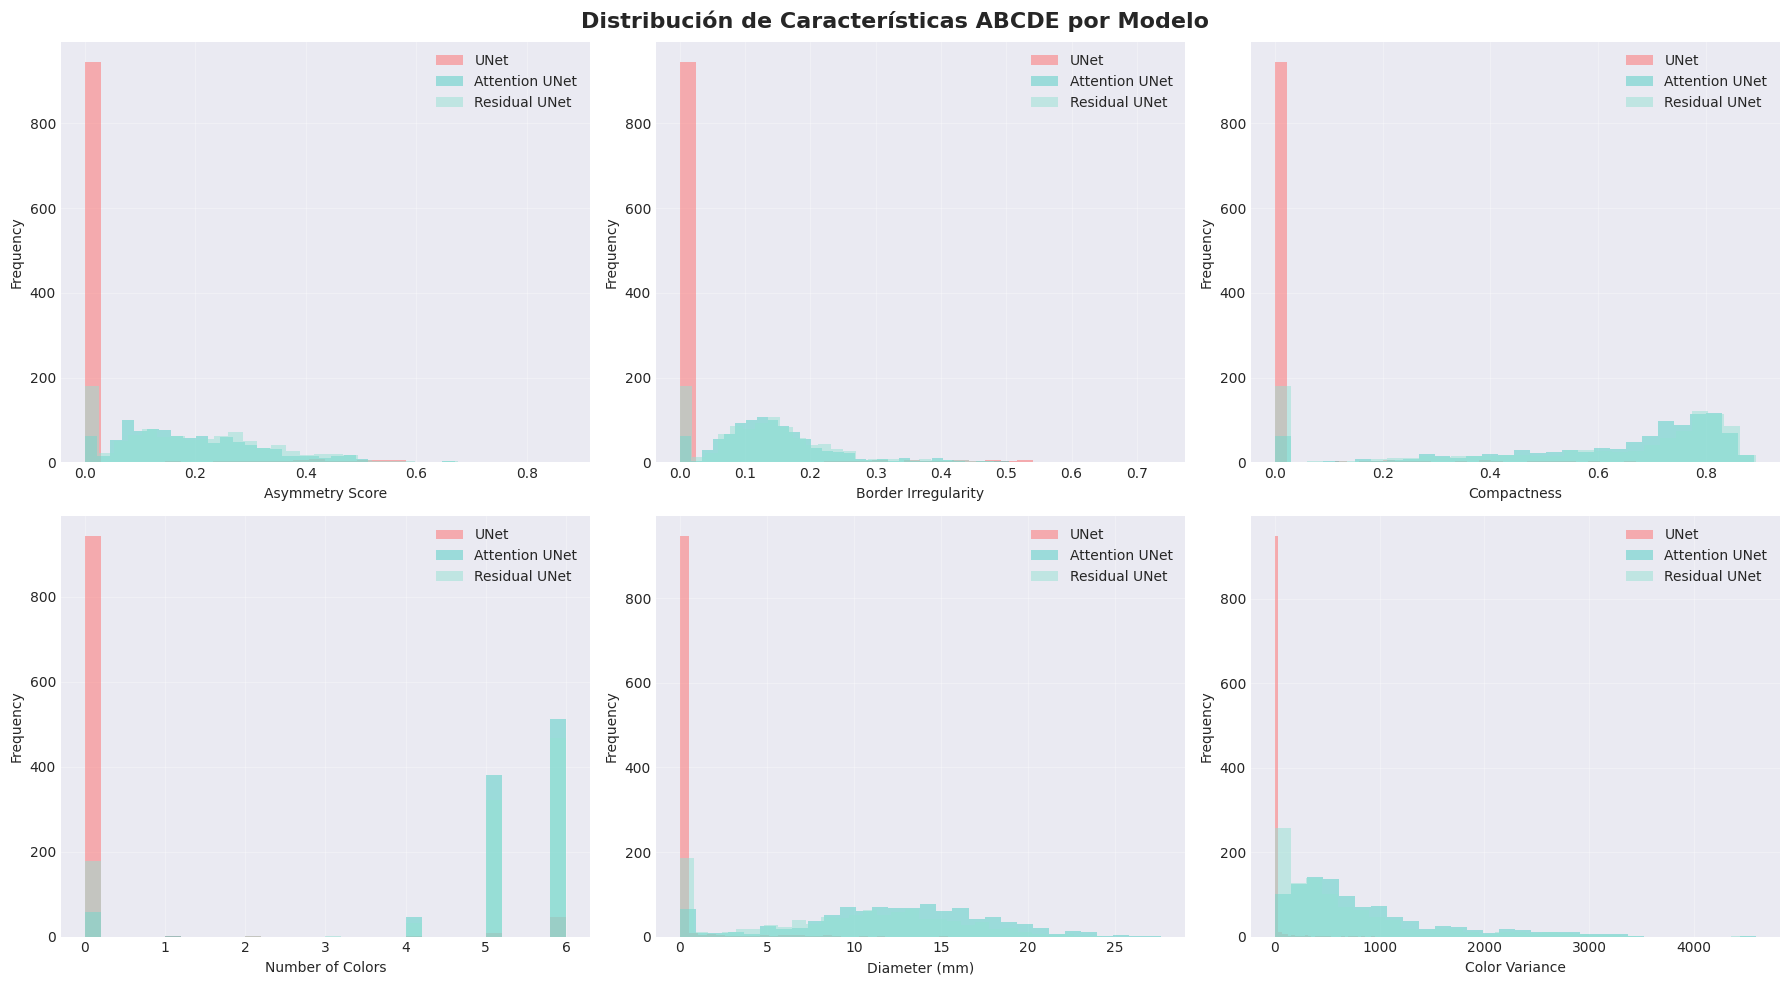

✓ Gráfico guardado: features_distributions.png


In [7]:
# ============================================================================
# CELDA 7: Visualizaciones - Distribuciones de Características
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de Características ABCDE por Modelo', 
             fontsize=16, fontweight='bold')

features_to_plot = [
    ('asymmetry_score', 'Asymmetry Score'),
    ('border_irregularity', 'Border Irregularity'),
    ('compactness', 'Compactness'),
    ('num_colors', 'Number of Colors'),
    ('diameter_mm', 'Diameter (mm)'),
    ('color_variance', 'Color Variance')
]

for idx, (feature, title) in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    for model_name, df in all_features.items():
        ax.hist(df[feature], bins=30, alpha=0.5, 
               label=model_name, 
               color=MODELS_CONFIG[model_name]['color'])
    
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/features_distributions.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: features_distributions.png")

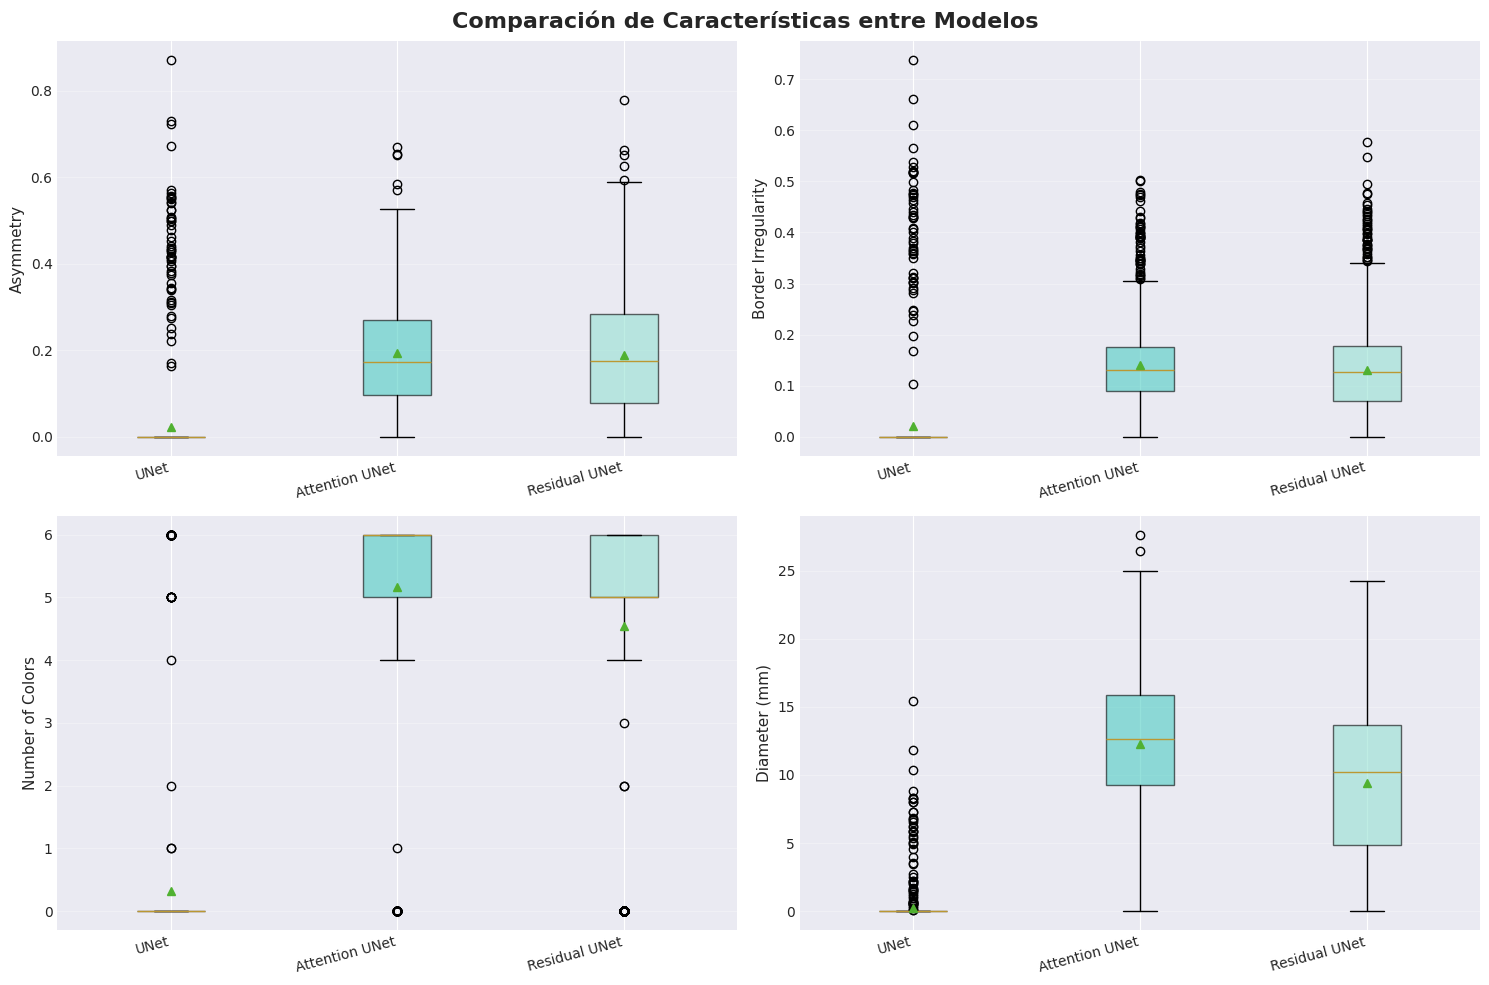

✓ Gráfico guardado: features_boxplots.png


In [8]:
# ============================================================================
# CELDA 8: Visualizaciones - Box Plots Comparativos
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparación de Características entre Modelos', 
             fontsize=16, fontweight='bold')

key_features = [
    ('asymmetry_score', 'Asymmetry'),
    ('border_irregularity', 'Border Irregularity'),
    ('num_colors', 'Number of Colors'),
    ('diameter_mm', 'Diameter (mm)')
]

for idx, (feature, title) in enumerate(key_features):
    ax = axes[idx // 2, idx % 2]
    
    # Preparar datos para boxplot
    data_to_plot = [df[feature].values for df in all_features.values()]
    
    bp = ax.boxplot(data_to_plot, labels=all_features.keys(),
                    patch_artist=True, showmeans=True)
    
    # Colorear boxes
    for patch, model_name in zip(bp['boxes'], all_features.keys()):
        patch.set_facecolor(MODELS_CONFIG[model_name]['color'])
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title, fontsize=11)
    ax.set_xticklabels(all_features.keys(), rotation=15, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/features_boxplots.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: features_boxplots.png")

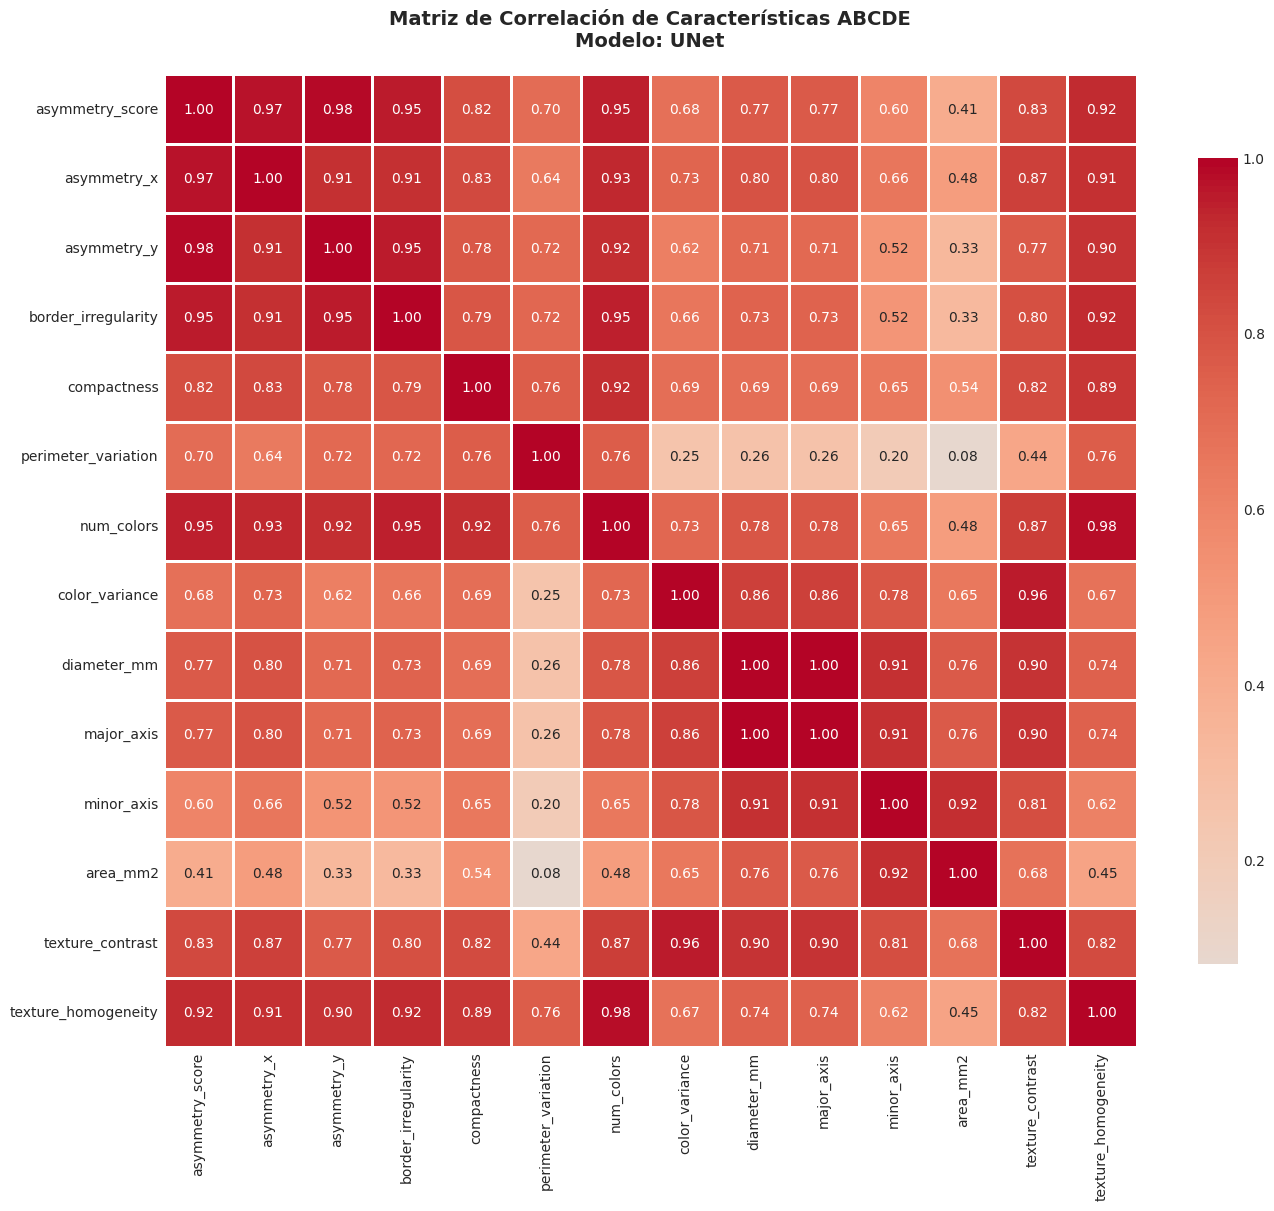

✓ Gráfico guardado: features_correlation.png


In [9]:
# ============================================================================
# CELDA 9: Visualizaciones - Correlación entre Características
# ============================================================================

# Seleccionar un modelo para análisis de correlación (el primero disponible)
model_for_corr = list(all_features.keys())[0]
df_corr = all_features[model_for_corr]

# Features numéricas para correlación
numeric_features = [
    'asymmetry_score', 'asymmetry_x', 'asymmetry_y',
    'border_irregularity', 'compactness', 'perimeter_variation',
    'num_colors', 'color_variance',
    'diameter_mm', 'major_axis', 'minor_axis', 'area_mm2',
    'texture_contrast', 'texture_homogeneity'
]

correlation_matrix = df_corr[numeric_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title(f'Matriz de Correlación de Características ABCDE\nModelo: {model_for_corr}', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/features_correlation.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: features_correlation.png")

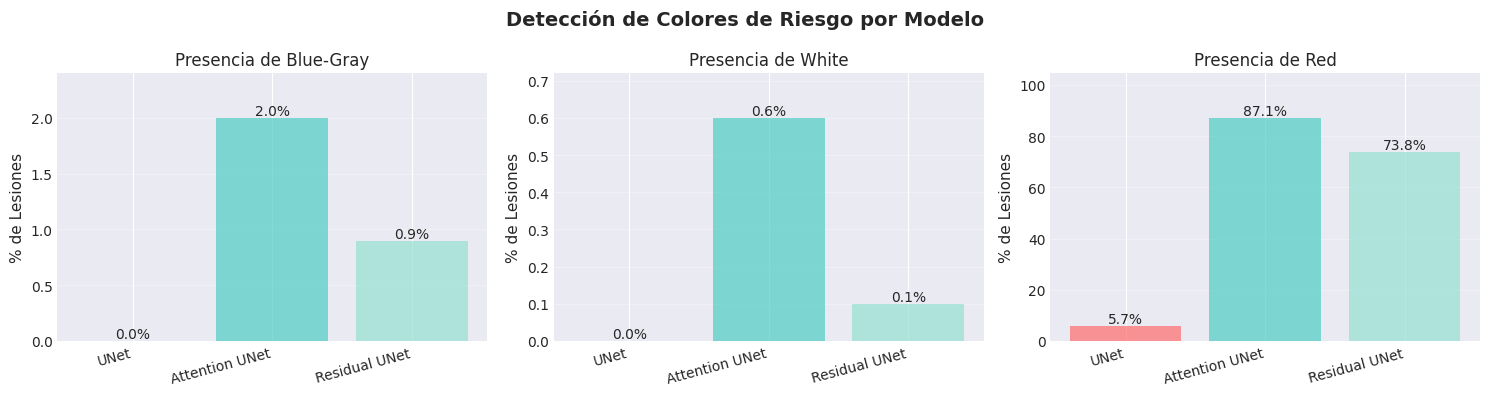

✓ Gráfico guardado: risk_colors_analysis.png


In [10]:
# ============================================================================
# CELDA 10: Análisis de Colores de Riesgo
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Detección de Colores de Riesgo por Modelo', 
             fontsize=14, fontweight='bold')

risk_colors = ['has_blue_gray', 'has_white', 'has_red']
risk_labels = ['Blue-Gray', 'White', 'Red']

for idx, (color_feature, label) in enumerate(zip(risk_colors, risk_labels)):
    ax = axes[idx]
    
    # Calcular porcentajes por modelo
    percentages = []
    models = []
    
    for model_name, df in all_features.items():
        pct = (df[color_feature].sum() / len(df)) * 100
        percentages.append(pct)
        models.append(model_name)
    
    # Crear gráfico de barras
    colors_list = [MODELS_CONFIG[m]['color'] for m in models]
    bars = ax.bar(range(len(models)), percentages, color=colors_list, alpha=0.7)
    
    # Añadir valores en las barras
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('% de Lesiones', fontsize=11)
    ax.set_title(f'Presencia de {label}', fontsize=12)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.set_ylim(0, max(percentages) * 1.2)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/risk_colors_analysis.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: risk_colors_analysis.png")

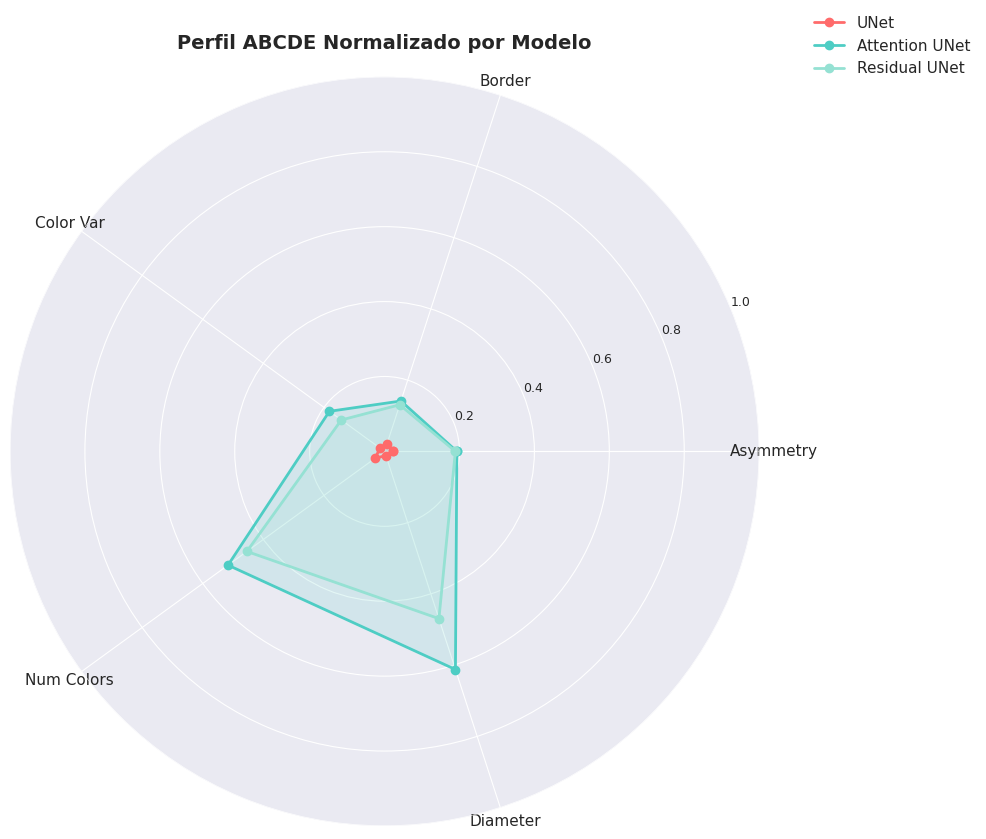

✓ Gráfico guardado: abcde_radar_chart.png


In [11]:
# ============================================================================
# CELDA 11: Radar Chart - Comparación ABCDE
# ============================================================================

from math import pi

# Calcular promedios normalizados para cada modelo
def normalize_features(df):
    """Normaliza features entre 0-1 para comparación"""
    return {
        'Asymmetry': df['asymmetry_score'].mean(),
        'Border': df['border_irregularity'].mean(),
        'Color Var': df['color_variance'].mean() / df['color_variance'].max(),
        'Num Colors': df['num_colors'].mean() / 10,  # Normalizar a escala 0-1
        'Diameter': min(df['diameter_mm'].mean() / 20, 1.0)  # Cap at 20mm
    }

categories = list(normalize_features(list(all_features.values())[0]).keys())
N = len(categories)

# Crear figura
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Ángulos para cada eje
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plot para cada modelo
for model_name, df in all_features.items():
    values = list(normalize_features(df).values())
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, 
            label=model_name, color=MODELS_CONFIG[model_name]['color'])
    ax.fill(angles, values, alpha=0.15, 
            color=MODELS_CONFIG[model_name]['color'])

# Configurar ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Perfil ABCDE Normalizado por Modelo', 
          size=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/abcde_radar_chart.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: abcde_radar_chart.png")

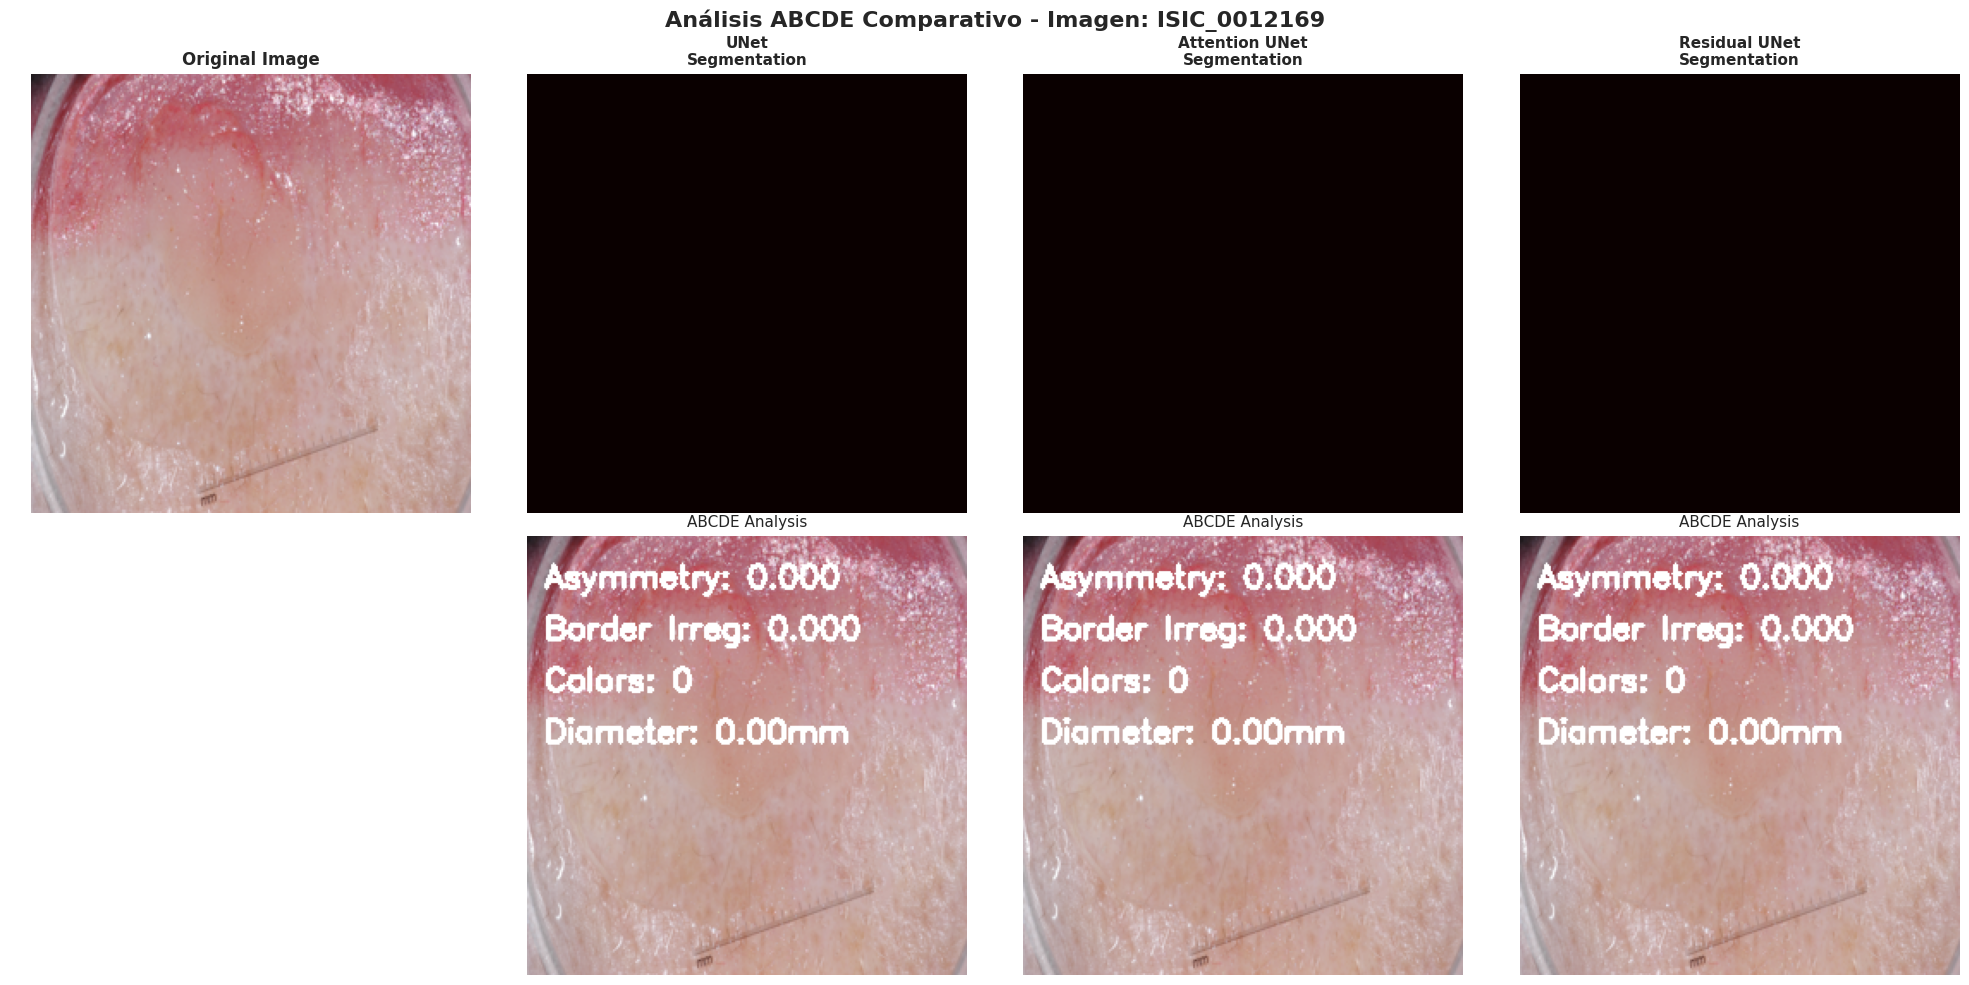


CARACTERÍSTICAS ABCDE - Imagen: ISIC_0012169

UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False

Attention UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False

Residual UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False


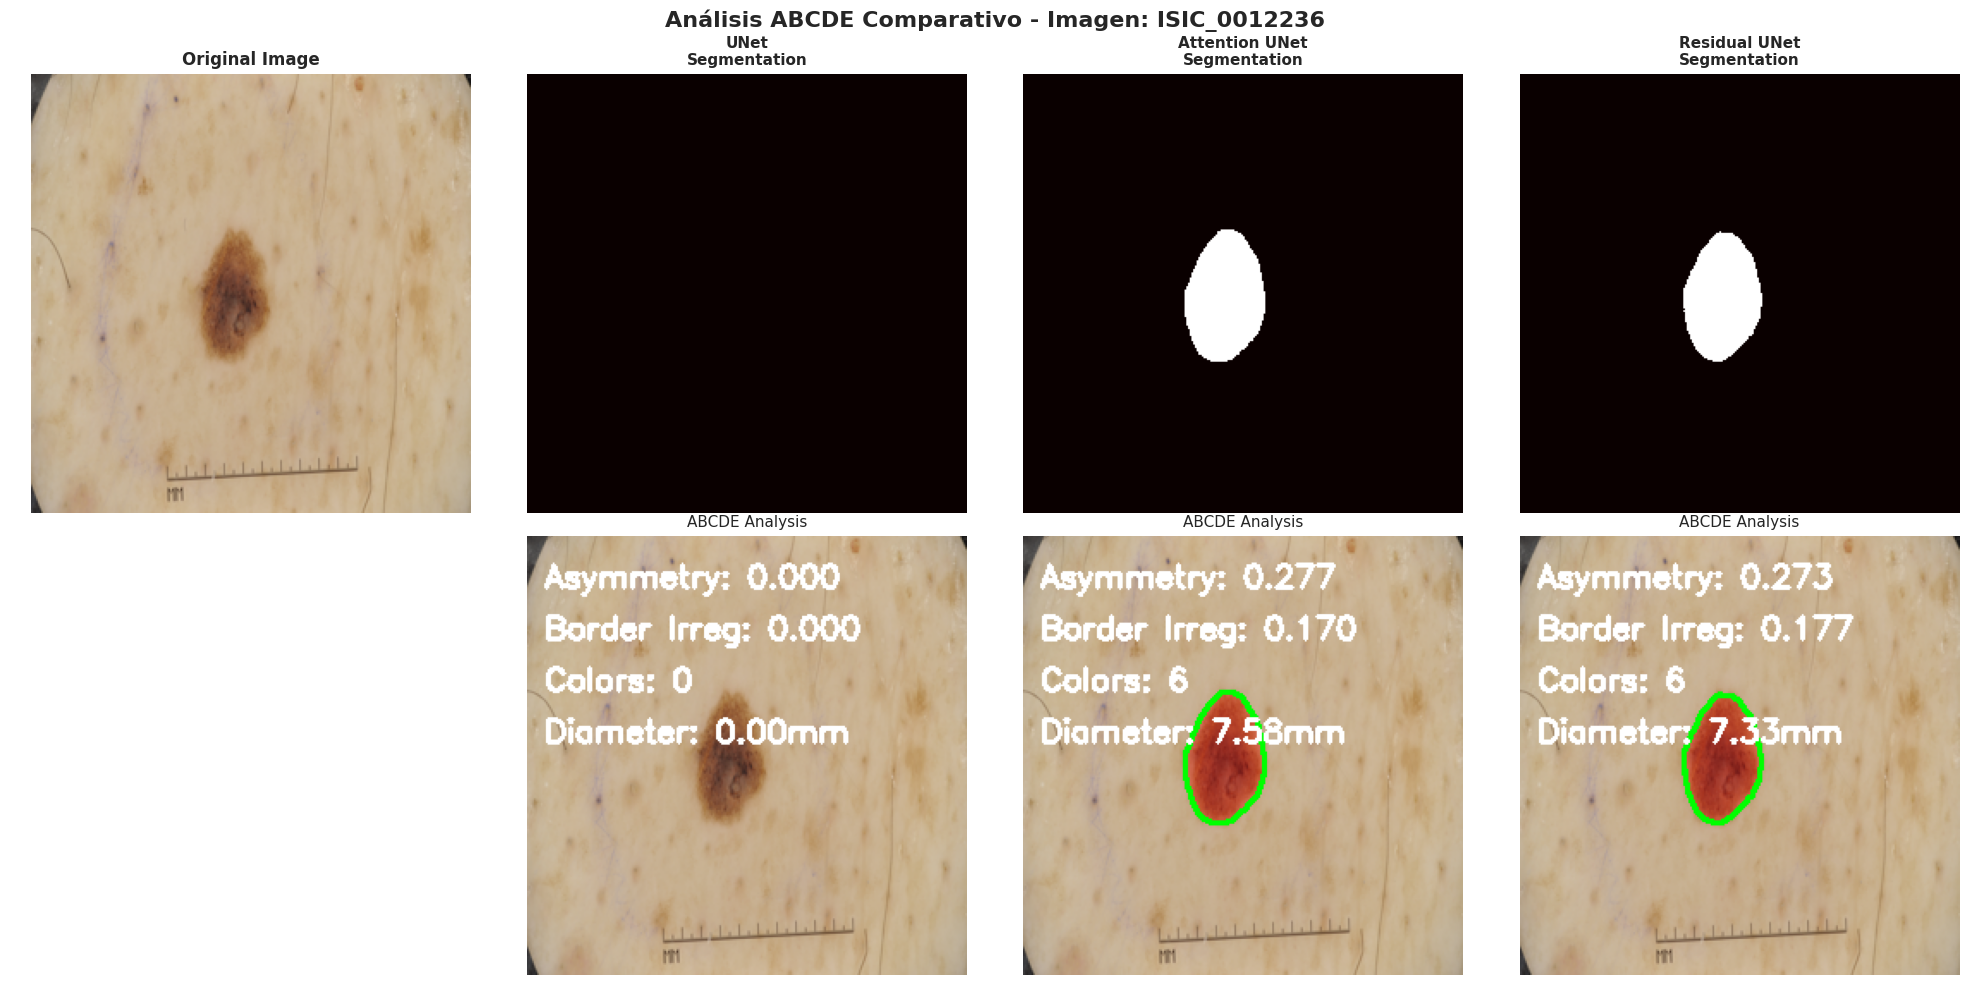


CARACTERÍSTICAS ABCDE - Imagen: ISIC_0012236

UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False

Attention UNet:
  A - Asymmetry: 0.277
  B - Border Irregularity: 0.170
  C - Colors: 6 (variance: 435.59)
  D - Diameter: 7.58 mm
  Risk Colors: Blue-Gray=False, White=False, Red=True

Residual UNet:
  A - Asymmetry: 0.273
  B - Border Irregularity: 0.177
  C - Colors: 6 (variance: 381.33)
  D - Diameter: 7.33 mm
  Risk Colors: Blue-Gray=False, White=False, Red=True


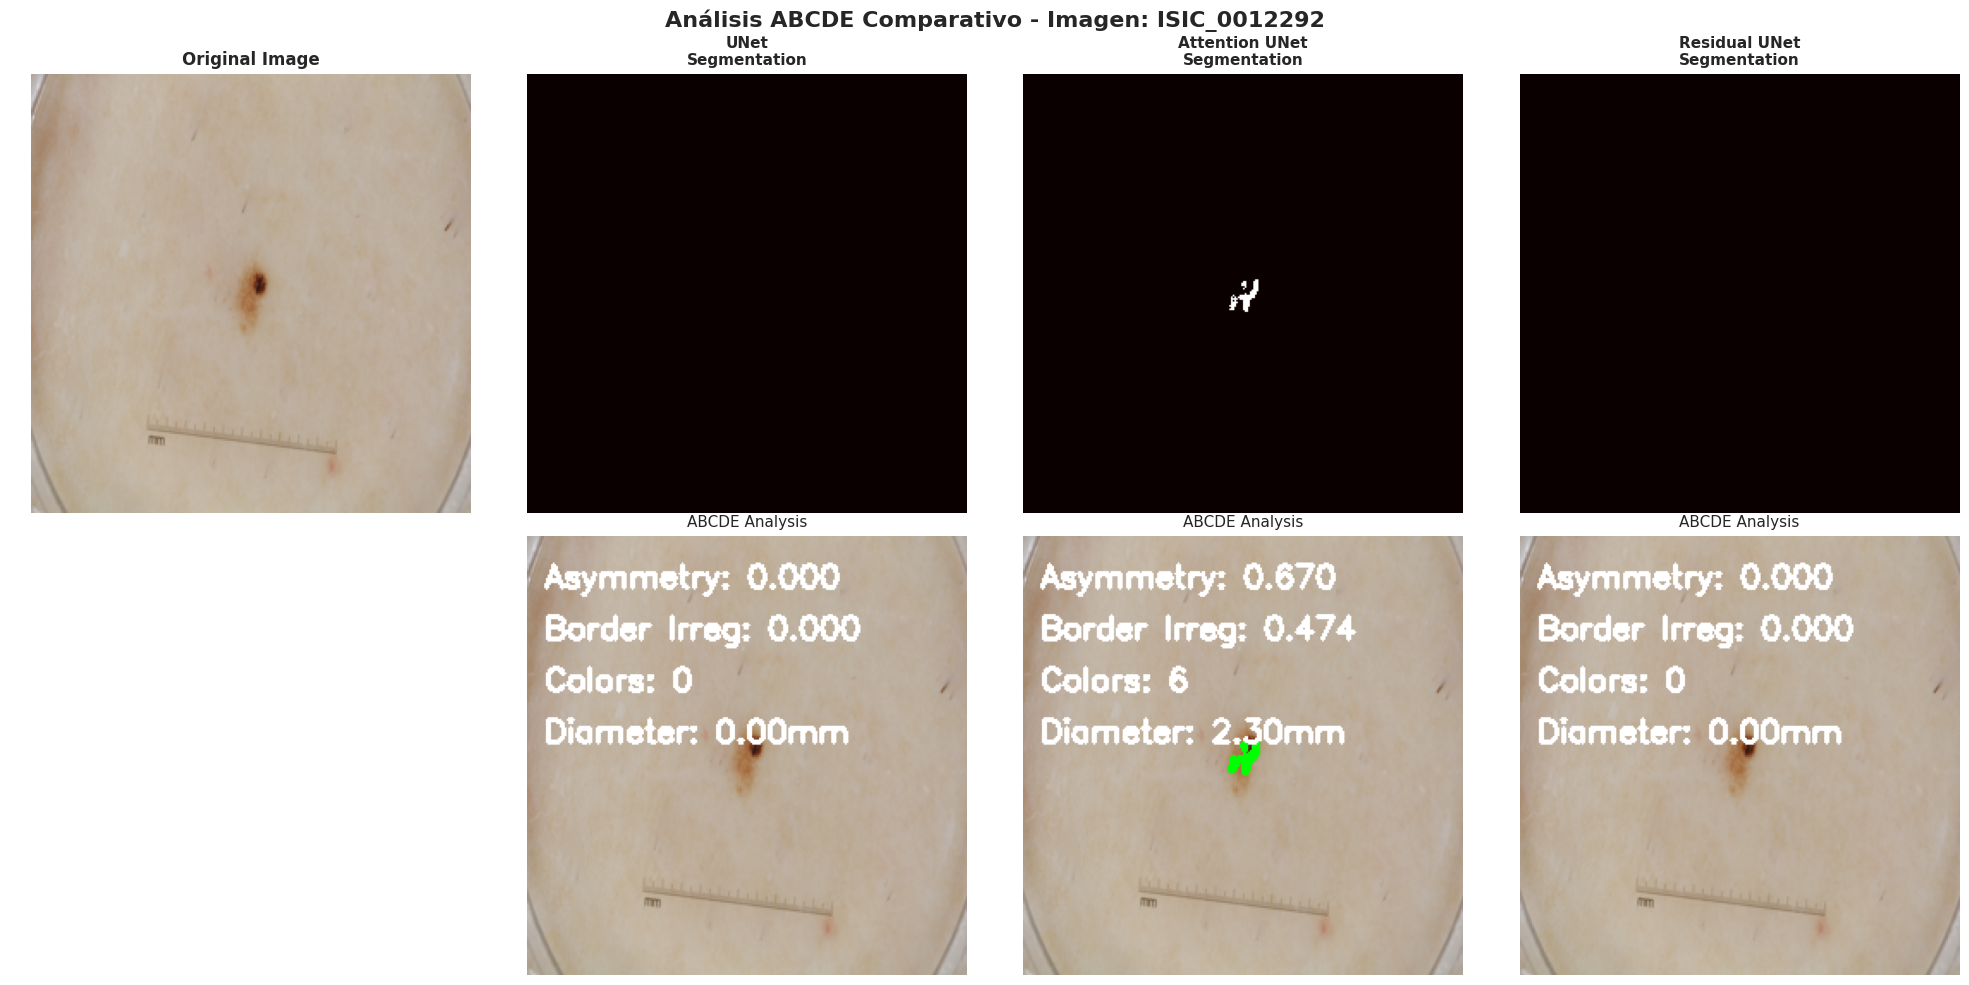


CARACTERÍSTICAS ABCDE - Imagen: ISIC_0012292

UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False

Attention UNet:
  A - Asymmetry: 0.670
  B - Border Irregularity: 0.474
  C - Colors: 6 (variance: 440.85)
  D - Diameter: 2.30 mm
  Risk Colors: Blue-Gray=False, White=False, Red=True

Residual UNet:
  A - Asymmetry: 0.000
  B - Border Irregularity: 0.000
  C - Colors: 0 (variance: 0.00)
  D - Diameter: 0.00 mm
  Risk Colors: Blue-Gray=False, White=False, Red=False

✓ Visualizaciones de ejemplos completadas


In [14]:
# ============================================================================
# CELDA 12: Ejemplos Visuales de Análisis Individual
# ============================================================================

def visualize_sample_analysis(image_id: str, n_models: int = 3):
    """
    Visualiza el análisis ABCDE de una imagen específica con todos los modelos
    """
    fig, axes = plt.subplots(2, n_models + 1, figsize=(20, 10))
    fig.suptitle(f'Análisis ABCDE Comparativo - Imagen: {image_id}', 
                 fontsize=16, fontweight='bold')
    
    # Cargar imagen original
    images_dir = Path(DATA_CONFIG['data_dir']) / 'raw' / \
                 f"isic2018_{DATA_CONFIG['split']}" / 'images'
    image_path = list(images_dir.glob(f"{image_id}.*"))[0]
    image_np, image_tensor = preprocess_image(str(image_path))
    image_rgb = (image_np * 255).astype(np.uint8)
    
    # Mostrar imagen original
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[1, 0].axis('off')
    
    # Para cada modelo
    for col, (model_name, model_config) in enumerate(list(MODELS_CONFIG.items())[:n_models], 1):
        
        # Cargar modelo y predecir
        model = load_model(model_config['path'], model_config['type'], device)
        mask = predict_mask(model, image_tensor, device)
        mask_uint8 = (mask * 255).astype(np.uint8)
        
        # Extraer features
        features = analyzer.analyze(image_rgb, mask_uint8)
        
        # Visualizar máscara
        axes[0, col].imshow(mask, cmap='hot')
        axes[0, col].set_title(f'{model_name}\nSegmentation', 
                              fontsize=11, fontweight='bold')
        axes[0, col].axis('off')
        
        # Visualizar overlay con features
        vis = analyzer.visualize_analysis(image_rgb, mask_uint8, features)
        axes[1, col].imshow(vis)
        axes[1, col].set_title(f'ABCDE Analysis', fontsize=11)
        axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{DATA_CONFIG['output_dir']}/visualizations/sample_{image_id}_comparison.png", 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Imprimir features numéricas
    print(f"\n{'='*80}")
    print(f"CARACTERÍSTICAS ABCDE - Imagen: {image_id}")
    print(f"{'='*80}")
    
    for model_name in list(MODELS_CONFIG.keys())[:n_models]:
        df = all_features[model_name]
        row = df[df['image_id'] == image_id].iloc[0]
        
        print(f"\n{model_name}:")
        print(f"  A - Asymmetry: {row['asymmetry_score']:.3f}")
        print(f"  B - Border Irregularity: {row['border_irregularity']:.3f}")
        print(f"  C - Colors: {row['num_colors']} (variance: {row['color_variance']:.2f})")
        print(f"  D - Diameter: {row['diameter_mm']:.2f} mm")
        print(f"  Risk Colors: Blue-Gray={row['has_blue_gray']}, White={row['has_white']}, Red={row['has_red']}")

# Seleccionar 3 imágenes aleatorias para visualizar
sample_ids = df_combined['image_id'].unique()[:3]

for sample_id in sample_ids:
    try:
        visualize_sample_analysis(sample_id, n_models=len(all_features))
    except Exception as e:
        print(f"Error visualizando {sample_id}: {e}")

print("\n✓ Visualizaciones de ejemplos completadas")

In [13]:
# ============================================================================
# CELDA 13: Resumen Final y Exportación
# ============================================================================

print("\n" + "="*80)
print("RESUMEN FINAL DEL ANÁLISIS")
print("="*80)

print(f"\n📊 Archivos generados:")
print(f"  • CSVs de features: {len(all_features)} modelos")
print(f"  • Visualizaciones: {len(list(Path(DATA_CONFIG['output_dir']).glob('visualizations/*.png')))} gráficos")

print(f"\n📁 Ubicación:")
print(f"  • Features: {DATA_CONFIG['output_dir']}/")
print(f"  • Visualizaciones: {DATA_CONFIG['output_dir']}/visualizations/")

print(f"\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")

# Crear resumen consolidado
summary = {
    'total_images': len(df_combined['image_id'].unique()),
    'models_analyzed': list(all_features.keys()),
    'split': DATA_CONFIG['split'],
    'key_findings': {}
}

for model_name, df in all_features.items():
    summary['key_findings'][model_name] = {
        'mean_asymmetry': float(df['asymmetry_score'].mean()),
        'mean_border_irregularity': float(df['border_irregularity'].mean()),
        'mean_num_colors': float(df['num_colors'].mean()),
        'mean_diameter_mm': float(df['diameter_mm'].mean()),
        'pct_blue_gray': float((df['has_blue_gray'].sum() / len(df)) * 100),
        'pct_white': float((df['has_white'].sum() / len(df)) * 100),
        'pct_red': float((df['has_red'].sum() / len(df)) * 100)
    }

# Guardar resumen
import json
summary_path = Path(DATA_CONFIG['output_dir']) / 'analysis_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Resumen guardado en: {summary_path}")


RESUMEN FINAL DEL ANÁLISIS

📊 Archivos generados:
  • CSVs de features: 3 modelos
  • Visualizaciones: 8 gráficos

📁 Ubicación:
  • Features: ../experiments/clinical_features/
  • Visualizaciones: ../experiments/clinical_features/visualizations/

✅ ANÁLISIS COMPLETADO EXITOSAMENTE

✓ Resumen guardado en: ../experiments/clinical_features/analysis_summary.json
